#Q1: Machine Learning Problem (Short Assignment)

## Setup Environment


In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## 2. Load Dataset

### Upload kaggle.json to Colab


In [4]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ninja111","key":"06fcb8e00aae75eb99d63aea1d06ad15"}'}

### Install and set up the Kaggle API

In [5]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


### Download and unzip the dataset

In [6]:
!kaggle datasets download -d meghakanojia/predicting-coupon-redemption
!unzip -q predicting-coupon-redemption.zip -d ./data


Dataset URL: https://www.kaggle.com/datasets/meghakanojia/predicting-coupon-redemption
License(s): unknown
  0% 0.00/11.4M [00:00<?, ?B/s]
100% 11.4M/11.4M [00:00<00:00, 1.14GB/s]


### Load and clean the DataSet

In [7]:
path = './data/train/'

df_train       = pd.read_csv(path + 'train.csv')
df_campaign    = pd.read_csv(path + 'campaign_data.csv')
df_coupon_map  = pd.read_csv(path + 'coupon_item_mapping.csv')
df_customer    = pd.read_csv(path + 'customer_demographics.csv')
df_trans       = pd.read_csv(path + 'customer_transaction_data.csv')
df_item        = pd.read_csv(path + 'item_data.csv')

# Verify
print(df_train.shape, df_campaign.shape, df_coupon_map.shape, df_customer.shape, df_trans.shape, df_item.shape)


(78369, 5) (28, 4) (92663, 2) (760, 7) (1324566, 7) (74066, 4)


In [8]:
print(df_train.head())
print(df_campaign.head())
print(df_coupon_map.head())
print(df_customer.head())
print(df_trans.head())
print(df_item.head())

   id  campaign_id  coupon_id  customer_id  redemption_status
0   1           13         27         1053                  0
1   2           13        116           48                  0
2   6            9        635          205                  0
3   7           13        644         1050                  0
4   9            8       1017         1489                  0
   campaign_id campaign_type start_date  end_date
0           24             Y   21/10/13  20/12/13
1           25             Y   21/10/13  22/11/13
2           20             Y   07/09/13  16/11/13
3           23             Y   08/10/13  15/11/13
4           21             Y   16/09/13  18/10/13
   coupon_id  item_id
0        105       37
1        107       75
2        494       76
3        522       77
4        518       77
   customer_id age_range marital_status  rented family_size no_of_children  \
0            1       70+        Married       0           2            NaN   
1            6     46-55        Married 

In [9]:
for name, df in [('train', df_train), ('campaign', df_campaign),
                 ('coupon_map', df_coupon_map), ('customer', df_customer),
                 ('trans', df_trans), ('item', df_item)]:
    print(f"\n{name}:")
    print(df.isnull().mean().loc[lambda x: x > 0].round(2))



train:
Series([], dtype: float64)

campaign:
Series([], dtype: float64)

coupon_map:
Series([], dtype: float64)

customer:
marital_status    0.43
no_of_children    0.71
dtype: float64

trans:
Series([], dtype: float64)

item:
Series([], dtype: float64)


In [10]:
df_customer['marital_status'] = df_customer['marital_status'].fillna('Unknown')
df_customer['no_of_children'] = df_customer['no_of_children'].fillna(0)


In [11]:
for name, df in [('train', df_train), ('campaign', df_campaign),
                 ('coupon_map', df_coupon_map), ('customer', df_customer),
                 ('trans', df_trans), ('item', df_item)]:
    print(f"\n{name}:")
    print(df.isnull().mean().loc[lambda x: x > 0].round(2))


train:
Series([], dtype: float64)

campaign:
Series([], dtype: float64)

coupon_map:
Series([], dtype: float64)

customer:
Series([], dtype: float64)

trans:
Series([], dtype: float64)

item:
Series([], dtype: float64)


### Merge DataFrames

In [12]:
# 1. train + campaign
df = df_train.merge(df_campaign, on='campaign_id', how='left')

# 2. Add coupon-item mapping
df = df.merge(df_coupon_map, on='coupon_id', how='left')

# 3. Add item info
df = df.merge(df_item, on='item_id', how='left')

# 4. Add customer demographics
df = df.merge(df_customer, on='customer_id', how='left')

# 5. Add transaction data (aggregate)
agg_trans = df_trans.groupby(['customer_id', 'item_id']).agg({
    'quantity': 'sum',
    'selling_price': 'mean',
    'other_discount': 'mean',
    'coupon_discount': 'mean'
}).reset_index()

df = df.merge(agg_trans, on=['customer_id', 'item_id'], how='left')
df= df.dropna()

## EDA

In [13]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 48501 entries, 258 to 6419317
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 48501 non-null  int64  
 1   campaign_id        48501 non-null  int64  
 2   coupon_id          48501 non-null  int64  
 3   customer_id        48501 non-null  int64  
 4   redemption_status  48501 non-null  int64  
 5   campaign_type      48501 non-null  object 
 6   start_date         48501 non-null  object 
 7   end_date           48501 non-null  object 
 8   item_id            48501 non-null  int64  
 9   brand              48501 non-null  int64  
 10  brand_type         48501 non-null  object 
 11  category           48501 non-null  object 
 12  age_range          48501 non-null  object 
 13  marital_status     48501 non-null  object 
 14  rented             48501 non-null  float64
 15  family_size        48501 non-null  object 
 16  no_of_children     4850

,id,campaign_id,coupon_id,customer_id,redemption_status,item_id,brand,rented,income_bracket,quantity,selling_price,other_discount,coupon_discount
count,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000,48501.000000
mean,62210.752665,11.980805,265.195852,822.560298,0.130142,30433.690934,960.844869,0.048844,4.977196,2.601287,110.495831,-23.331039,-1.347808
std,37348.651308,5.231804,347.270723,477.312970,0.336463,18652.580319,1140.978277,0.215545,2.360154,6.278896,102.333613,38.527315,7.523760
min,15.000000,1.000000,1.000000,1.000000,0.000000,31.000000,1.000000,0.000000,1.000000,1.000000,1.070000,-1175.100000,-213.360000
25%,29780.000000,8.000000,21.000000,416.000000,0.000000,14775.000000,133.000000,0.000000,4.000000,1.000000,57.943333,-35.218750,0.000000
50%,62794.000000,13.000000,23.000000,821.000000,0.000000,26942.000000,686.000000,0.000000,5.000000,1.000000,89.050000,-10.330000,0.000000
75%,93701.000000,13.000000,571.000000,1263.000000,0.000000,46238.000000,1149.000000,0.000000,6.000000,2.000000,127.880000,0.000000,0.000000
max,128500.000000,30.000000,1112.000000,1581.000000,1.000000,74054.000000,5468.000000,1.000000,12.000000,511.000000,2109.770000,0.000000,0.000000


###Univariate Analysis

Target Variable

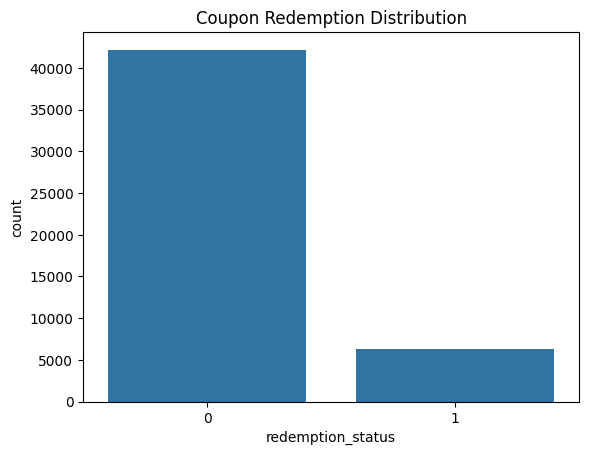

Redemption Rate:
 redemption_status
0    86.985835
1    13.014165
Name: proportion, dtype: float64


In [14]:
sns.countplot(x='redemption_status', data=df)
plt.title('Coupon Redemption Distribution')
plt.show()

# Print percentage
redemption_rate = df['redemption_status'].value_counts(normalize=True) * 100
print("Redemption Rate:\n", redemption_rate)


In [15]:
# Define Numerical ,categorical columns
num_cols = ['quantity', 'selling_price', 'other_discount', 'coupon_discount']
categorical_cols = ['campaign_type','brand_type','category', 'age_range','family_size','no_of_children', 'marital_status', 'rented', 'income_bracket']

Numerical

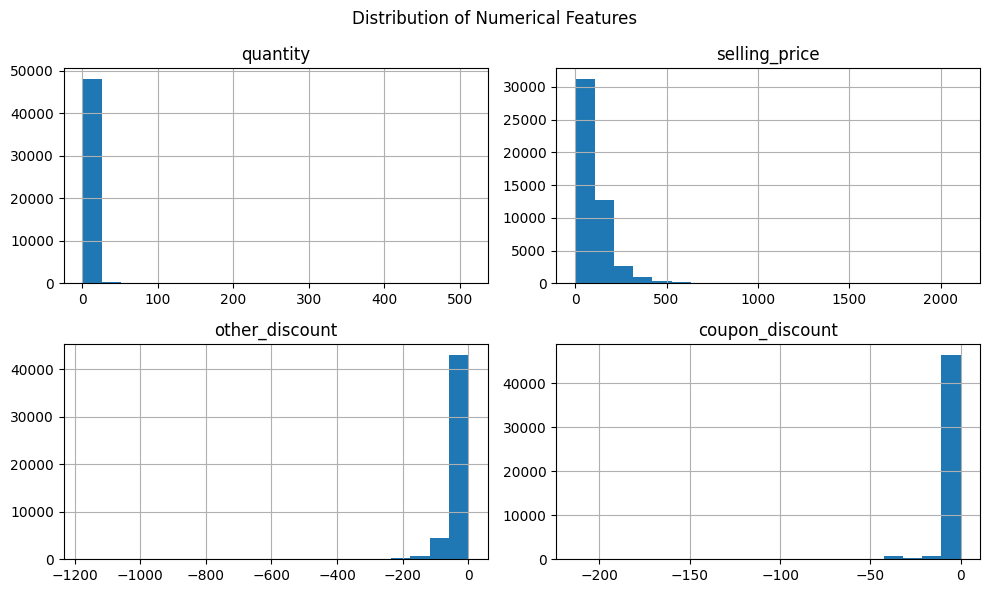

In [16]:

df[num_cols].hist(figsize=(10, 6), bins=20)
plt.suptitle("Distribution of Numerical Features")
plt.tight_layout()
plt.show()


Categorical

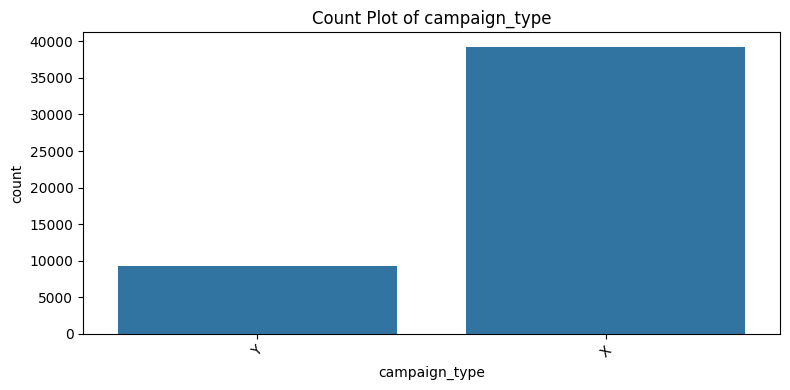

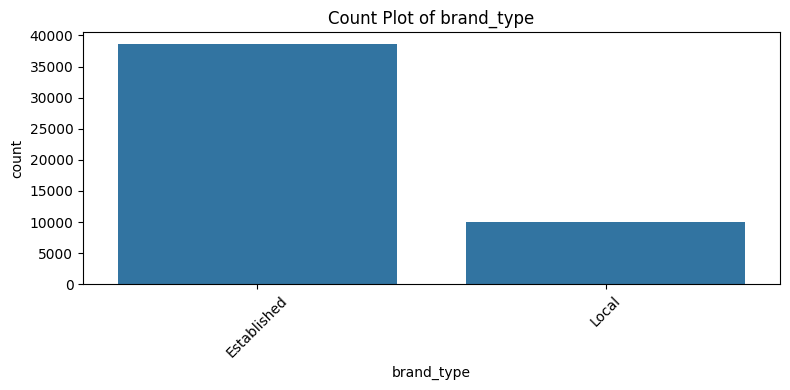

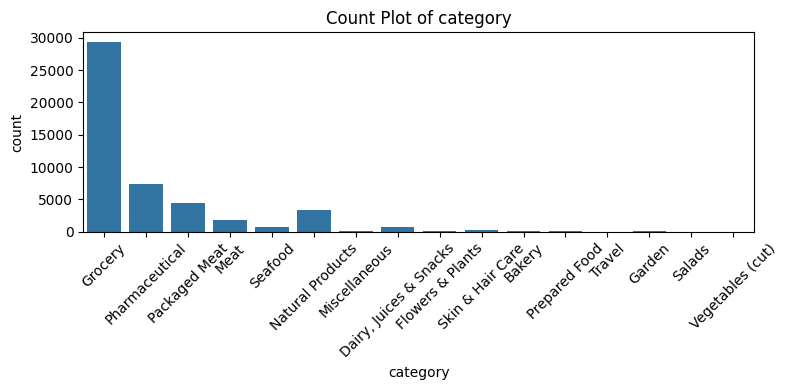

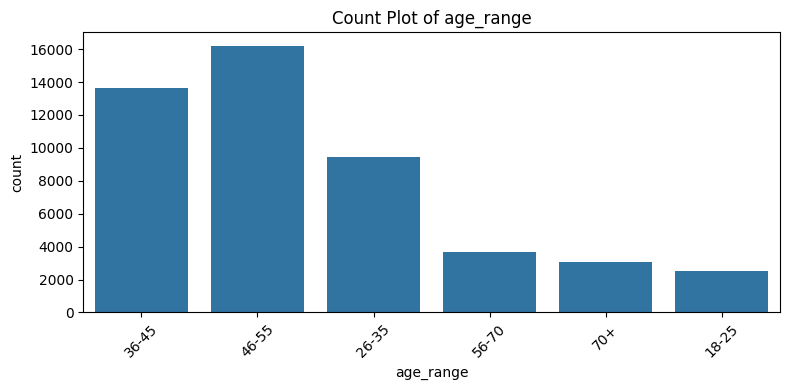

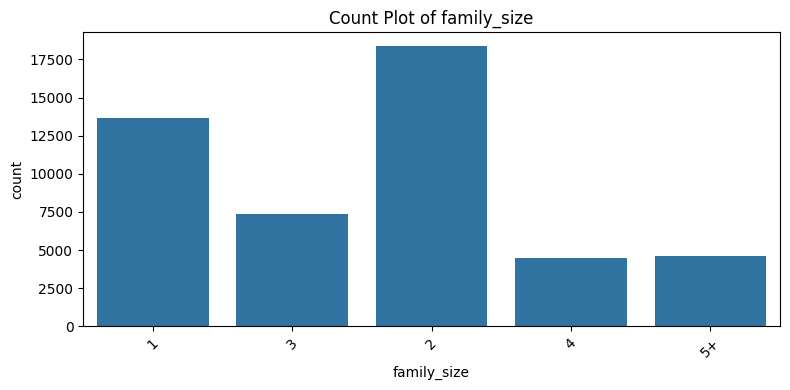

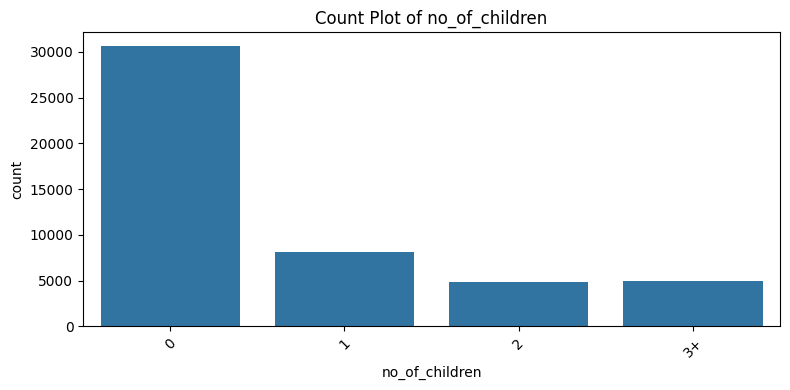

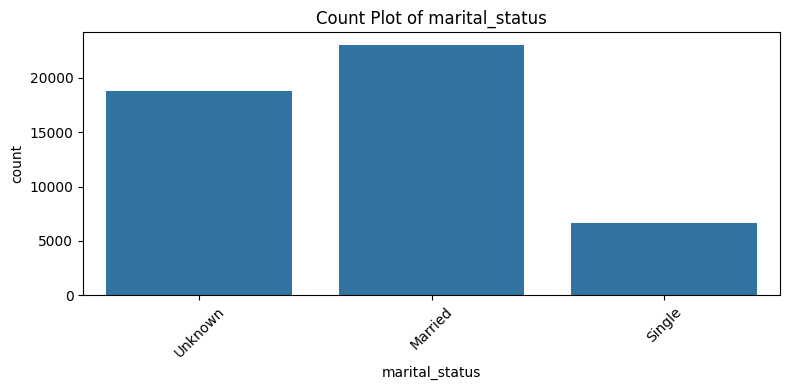

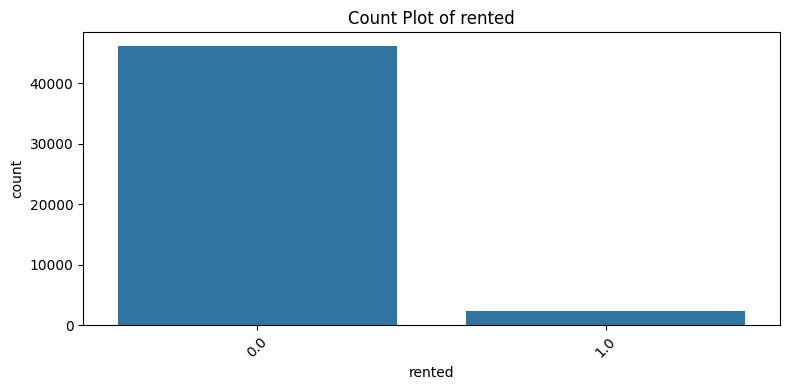

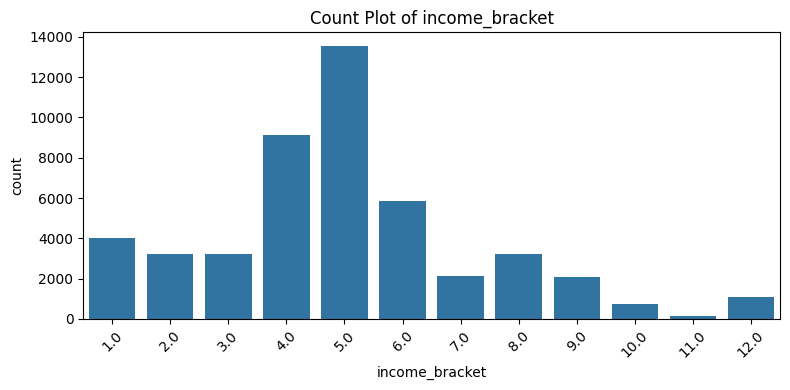

In [17]:
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Bivariate Analysis

Numerical vs Numerical

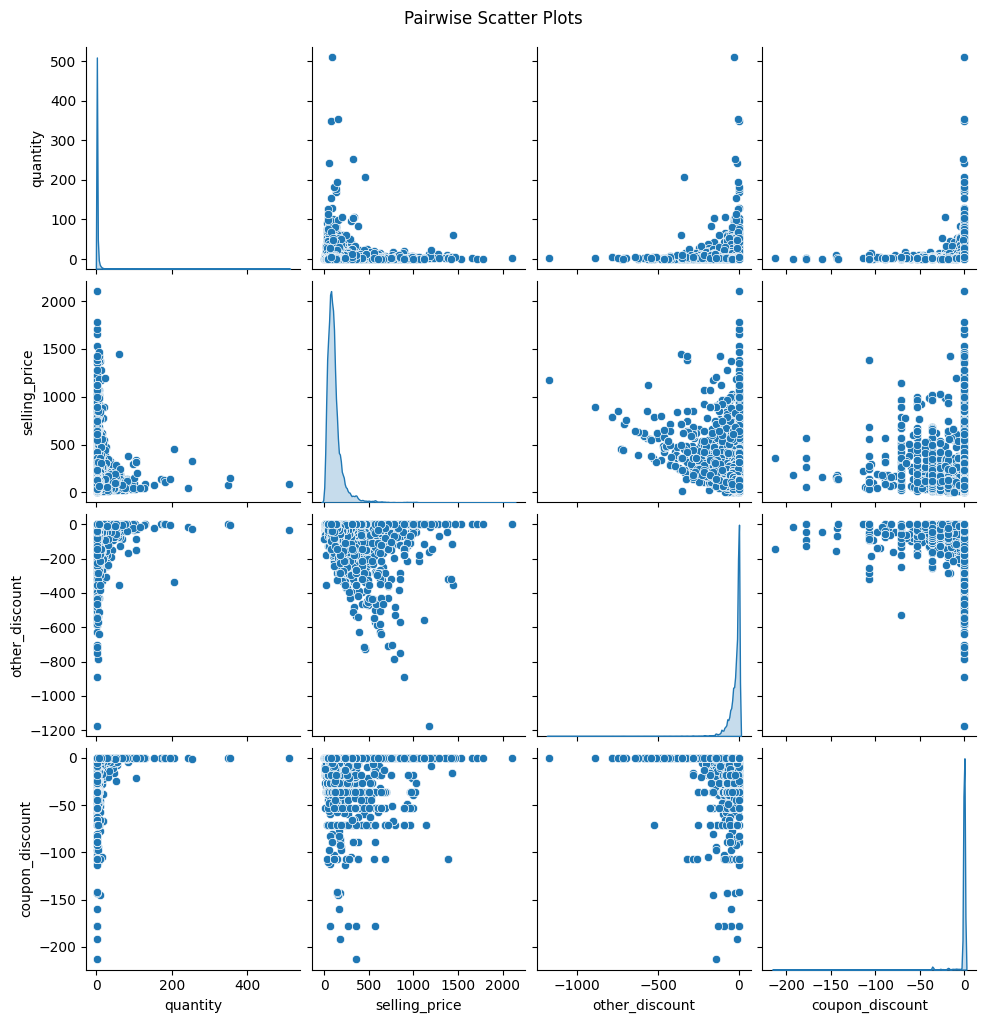

In [18]:
# Pairwise scatterplots
sns.pairplot(df[num_cols], diag_kind='kde')  # 'kde' for smooth histograms
plt.suptitle('Pairwise Scatter Plots', y=1.02)
plt.show()

Categorical vs Numerical

Categorical vs Numerical

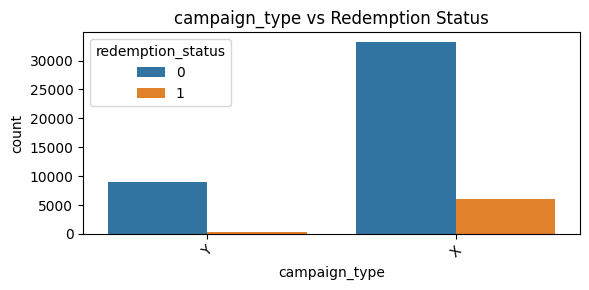

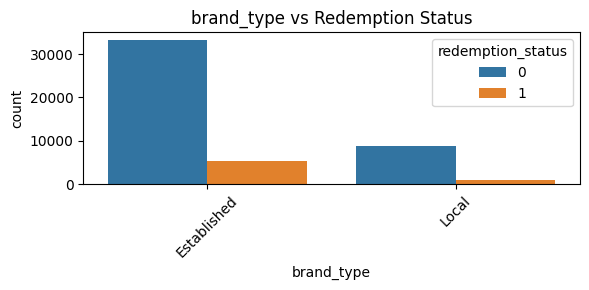

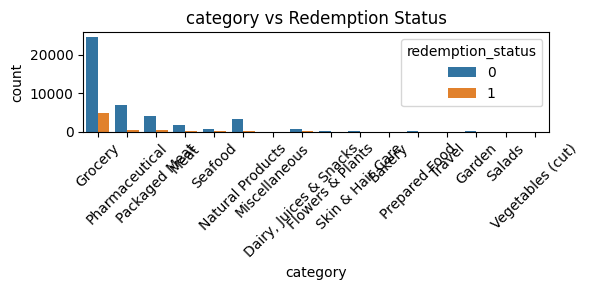

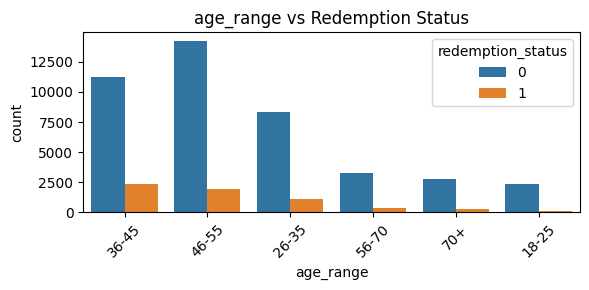

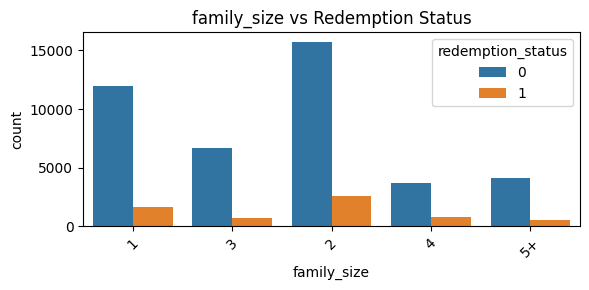

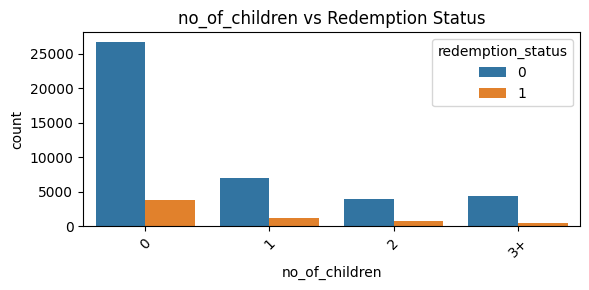

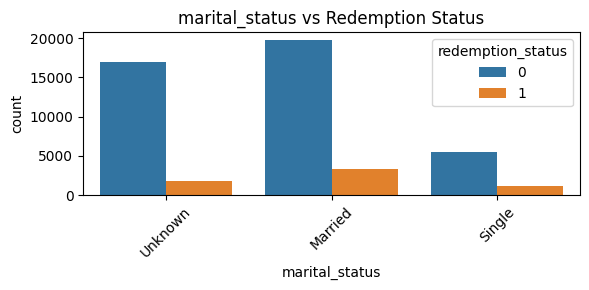

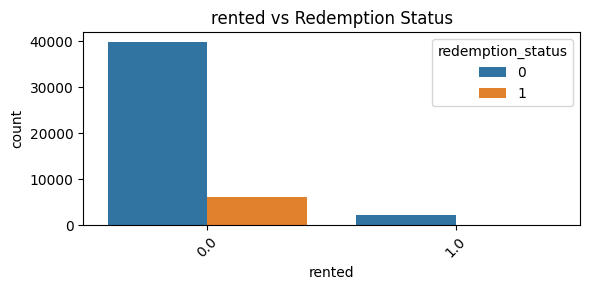

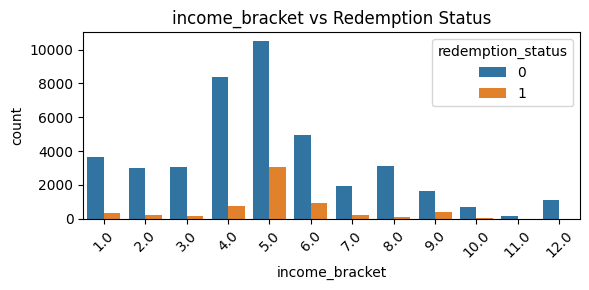

In [19]:
for col in categorical_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue='redemption_status')
    plt.title(f"{col} vs Redemption Status")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

###Correlation Check

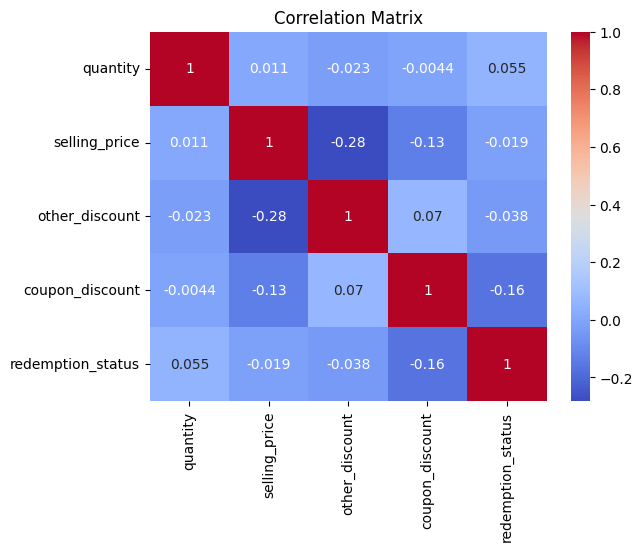

In [20]:
# Correlation between numeric variables
corr = df[num_cols + ['redemption_status']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


Outliers check

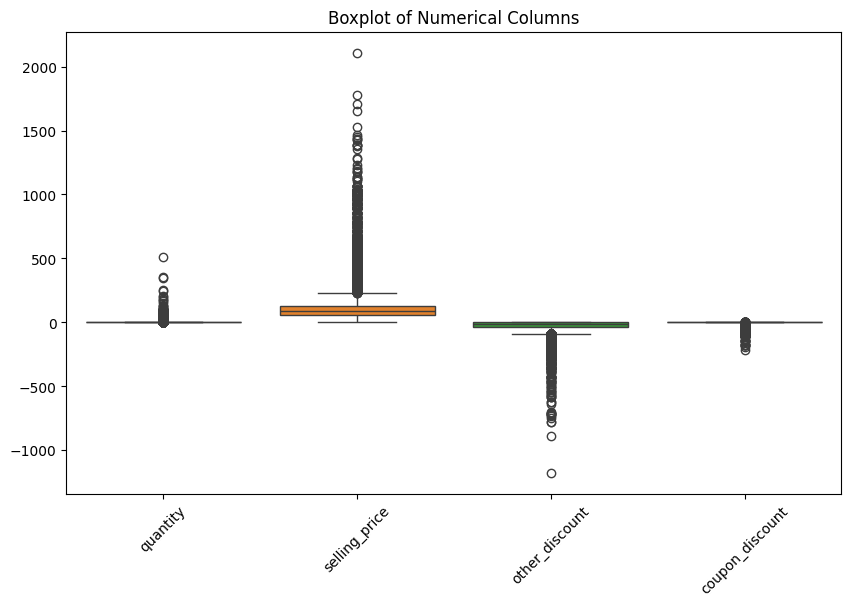

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[num_cols])
plt.title('Boxplot of Numerical Columns')
plt.xticks(rotation=45)
plt.show()

#Feature Engineering

Campaign Duration calculate

In [22]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['campaign_duration'] = (df['end_date'] - df['start_date']).dt.days


/tmp/ipython-input-22-653005193.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['start_date'] = pd.to_datetime(df['start_date'])
/tmp/ipython-input-22-653005193.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['end_date'] = pd.to_datetime(df['end_date'])


Coupon Coverage (Number of Items per Coupon)

In [23]:
coupon_item_count = df.groupby('coupon_id')['item_id'].nunique().reset_index()
coupon_item_count.columns = ['coupon_id', 'coupon_item_count']

df = df.merge(coupon_item_count, on='coupon_id', how='left')


Coupon Diversity: Brand & Category Count

In [24]:
brand_cat_count = df.groupby('coupon_id').agg({
    'brand': 'nunique',
    'category': 'nunique'
}).reset_index()
brand_cat_count.columns = ['coupon_id', 'unique_brands', 'unique_categories']

df = df.merge(brand_cat_count, on='coupon_id', how='left')


Customer RFM-style Features

In [25]:
# Aggregate customer transaction data
customer_features = df.groupby('customer_id').agg({
    'quantity': ['sum', 'mean'],
    'selling_price': 'mean',
    'other_discount': 'mean',
    'coupon_discount': 'mean'
}).reset_index()

# Rename columns
customer_features.columns = ['customer_id', 'total_qty', 'avg_qty', 'avg_price', 'avg_other_disc', 'avg_coupon_disc']

df = df.merge(customer_features, on='customer_id', how='left')


Past Purchase Overlap (customer bought item in coupon before)

In [26]:
df['purchased_coupon_item_before'] = df['quantity'].notna().astype(int)


Encoding Categorical Features (Label/One-Hot for Logistic Regression)

In [27]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


Feature Selection

In [28]:
features = [
    'campaign_duration', 'coupon_item_count', 'unique_brands', 'unique_categories',
    'total_qty', 'avg_qty', 'avg_price', 'avg_other_disc', 'avg_coupon_disc',
    'purchased_coupon_item_before'
]

# Add the encoded categorical columns
features += [col for col in df.columns if any(prefix in col for prefix in categorical_cols)]

X = df[features]
y = df['redemption_status']


In [29]:
pd.set_option('display.max_columns', None)
df.head()


,id,campaign_id,coupon_id,customer_id,redemption_status,start_date,end_date,item_id,brand,quantity,selling_price,other_discount,coupon_discount,campaign_duration,coupon_item_count,unique_brands,unique_categories,total_qty,avg_qty,avg_price,avg_other_disc,avg_coupon_disc,purchased_coupon_item_before,campaign_type_Y,brand_type_Local,"category_Dairy, Juices & Snacks",category_Flowers & Plants,category_Garden,category_Grocery,category_Meat,category_Miscellaneous,category_Natural Products,category_Packaged Meat,category_Pharmaceutical,category_Prepared Food,category_Salads,category_Seafood,category_Skin & Hair Care,category_Travel,category_Vegetables (cut),age_range_26-35,age_range_36-45,age_range_46-55,age_range_56-70,age_range_70+,family_size_2,family_size_3,family_size_4,family_size_5+,no_of_children_1,no_of_children_2,no_of_children_3+,marital_status_Single,marital_status_Unknown,rented_1.0,income_bracket_2.0,income_bracket_3.0,income_bracket_4.0,income_bracket_5.0,income_bracket_6.0,income_bracket_7.0,income_bracket_8.0,income_bracket_9.0,income_bracket_10.0,income_bracket_11.0,income_bracket_12.0
0,15,29,538,368,0,2012-08-10,2012-11-30,9962,278,1.0,45.95,0.00,0.0,112,4,1,1,1043.0,9.657407,89.444186,-18.060726,0.000000,1,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
1,15,29,538,368,0,2012-08-10,2012-11-30,29027,278,1.0,45.95,0.00,0.0,112,4,1,1,1043.0,9.657407,89.444186,-18.060726,0.000000,1,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
2,21,13,1028,89,0,2013-05-19,2013-05-07,52056,1639,1.0,71.24,-28.14,0.0,-12,4,1,1,43.0,1.791667,100.989792,-46.847500,0.000000,1,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
3,22,9,705,712,0,2013-11-03,2013-12-04,4904,714,2.0,113.63,-39.18,0.0,31,94,1,1,132.0,1.913043,126.625507,-44.995072,-2.460705,1,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
4,22,9,705,712,0,2013-11-03,2013-12-04,30345,714,2.0,178.10,-54.85,0.0,31,94,1,1,132.0,1.913043,126.625507,-44.995072,-2.460705,1,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48501 entries, 0 to 48500
Data columns (total 66 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               48501 non-null  int64         
 1   campaign_id                      48501 non-null  int64         
 2   coupon_id                        48501 non-null  int64         
 3   customer_id                      48501 non-null  int64         
 4   redemption_status                48501 non-null  int64         
 5   start_date                       48501 non-null  datetime64[ns]
 6   end_date                         48501 non-null  datetime64[ns]
 7   item_id                          48501 non-null  int64         
 8   brand                            48501 non-null  int64         
 9   quantity                         48501 non-null  float64       
 10  selling_price                    48501 non-null  float64  

# Model Training & Evaluation

##Logistic Regression & DecisionTreeClassifier

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Logistic Regression with class weights
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Decision Tree with max depth + class weight
dt = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

Evaluation Function

In [33]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f" {model_name} Evaluation:")
    print(classification_report(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [34]:
evaluate_model(lr, X_test, y_test, "Logistic Regression")
evaluate_model(dt, X_test, y_test, "Decision Tree")


 Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     12657
           1       0.44      0.83      0.57      1894

    accuracy                           0.84     14551
   macro avg       0.70      0.83      0.74     14551
weighted avg       0.90      0.84      0.86     14551

AUC Score: 0.8967239684973836
Confusion Matrix:
 [[10637  2020]
 [  331  1563]]
 Decision Tree Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83     12657
           1       0.34      0.97      0.50      1894

    accuracy                           0.75     14551
   macro avg       0.67      0.84      0.67     14551
weighted avg       0.91      0.75      0.79     14551

AUC Score: 0.9204509210149456
Confusion Matrix:
 [[9074 3583]
 [  64 1830]]


##PCA

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Select only numeric columns for PCA
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
exclude_cols = ['id', 'customer_id', 'coupon_id', 'campaign_id', 'redemption_status']
pca_cols = [col for col in numeric_cols if col not in exclude_cols]

# Scale numeric columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[pca_cols])

# Apply PCA
pca = PCA(n_components=0.95)  # keep 95% variance
X_pca = pca.fit_transform(X_scaled)


In [36]:
# PCA result as dataframe
X_pca_df = pd.DataFrame(X_pca, index=X.index)

# Get remaining features (excluding pca_cols)
other_cols = X.drop(columns=pca_cols)

# Combine
X_final = pd.concat([X_pca_df, other_cols.reset_index(drop=True)], axis=1)


In [37]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48501 entries, 0 to 48500
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   0                                48501 non-null  float64
 1   1                                48501 non-null  float64
 2   2                                48501 non-null  float64
 3   3                                48501 non-null  float64
 4   4                                48501 non-null  float64
 5   5                                48501 non-null  float64
 6   6                                48501 non-null  float64
 7   7                                48501 non-null  float64
 8   campaign_type_Y                  48501 non-null  bool   
 9   brand_type_Local                 48501 non-null  bool   
 10  category_Dairy, Juices & Snacks  48501 non-null  bool   
 11  category_Flowers & Plants        48501 non-null  bool   
 12  category_Garden   

In [38]:
# PCA columns will be unnamed, so let's name them
X_pca_df.columns = [f'PC{i+1}' for i in range(X_pca_df.shape[1])]

# Recombine with non-PCA features
X_final = pd.concat([X_pca_df, other_cols.reset_index(drop=True)], axis=1)

# Now print column names
print(X_final.columns.tolist())


['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'campaign_type_Y', 'brand_type_Local', 'category_Dairy, Juices & Snacks', 'category_Flowers & Plants', 'category_Garden', 'category_Grocery', 'category_Meat', 'category_Miscellaneous', 'category_Natural Products', 'category_Packaged Meat', 'category_Pharmaceutical', 'category_Prepared Food', 'category_Salads', 'category_Seafood', 'category_Skin & Hair Care', 'category_Travel', 'category_Vegetables (cut)', 'age_range_26-35', 'age_range_36-45', 'age_range_46-55', 'age_range_56-70', 'age_range_70+', 'family_size_2', 'family_size_3', 'family_size_4', 'family_size_5+', 'no_of_children_1', 'no_of_children_2', 'no_of_children_3+', 'marital_status_Single', 'marital_status_Unknown', 'rented_1.0', 'income_bracket_2.0', 'income_bracket_3.0', 'income_bracket_4.0', 'income_bracket_5.0', 'income_bracket_6.0', 'income_bracket_7.0', 'income_bracket_8.0', 'income_bracket_9.0', 'income_bracket_10.0', 'income_bracket_11.0', 'income_bracket_12.0']


##xgboost

In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.3, stratify=y, random_state=42
)

# SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# Convert to DMatrix (XGBoost format)
dtrain = xgb.DMatrix(X_res, label=y_res)
dvalid = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 5,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

#  Train model with early stopping
evals = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=False
)

#  Predict probabilities
y_proba = model.predict(dvalid)

# Optimize threshold using F1
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"\nBest Threshold: {best_thresh:.2f}")

# Predict labels using best threshold
y_pred = (y_proba >= best_thresh).astype(int)

# Evaluation
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))



Best Threshold: 0.76

Confusion Matrix:
[[12520   137]
 [  123  1771]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12657
           1       0.93      0.94      0.93      1894

    accuracy                           0.98     14551
   macro avg       0.96      0.96      0.96     14551
weighted avg       0.98      0.98      0.98     14551

ROC-AUC Score: 0.9961488769690492


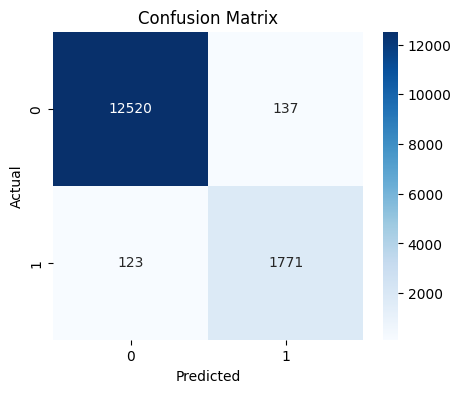

In [40]:
# Confusion Matrix Plot
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#API

In [41]:
print(X.columns.tolist())

['campaign_duration', 'coupon_item_count', 'unique_brands', 'unique_categories', 'total_qty', 'avg_qty', 'avg_price', 'avg_other_disc', 'avg_coupon_disc', 'purchased_coupon_item_before', 'campaign_type_Y', 'brand_type_Local', 'category_Dairy, Juices & Snacks', 'category_Flowers & Plants', 'category_Garden', 'category_Grocery', 'category_Meat', 'category_Miscellaneous', 'category_Natural Products', 'category_Packaged Meat', 'category_Pharmaceutical', 'category_Prepared Food', 'category_Salads', 'category_Seafood', 'category_Skin & Hair Care', 'category_Travel', 'category_Vegetables (cut)', 'age_range_26-35', 'age_range_36-45', 'age_range_46-55', 'age_range_56-70', 'age_range_70+', 'family_size_2', 'family_size_3', 'family_size_4', 'family_size_5+', 'no_of_children_1', 'no_of_children_2', 'no_of_children_3+', 'marital_status_Single', 'marital_status_Unknown', 'rented_1.0', 'income_bracket_2.0', 'income_bracket_3.0', 'income_bracket_4.0', 'income_bracket_5.0', 'income_bracket_6.0', 'incom

In [42]:
print(X_final.columns.tolist())

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'campaign_type_Y', 'brand_type_Local', 'category_Dairy, Juices & Snacks', 'category_Flowers & Plants', 'category_Garden', 'category_Grocery', 'category_Meat', 'category_Miscellaneous', 'category_Natural Products', 'category_Packaged Meat', 'category_Pharmaceutical', 'category_Prepared Food', 'category_Salads', 'category_Seafood', 'category_Skin & Hair Care', 'category_Travel', 'category_Vegetables (cut)', 'age_range_26-35', 'age_range_36-45', 'age_range_46-55', 'age_range_56-70', 'age_range_70+', 'family_size_2', 'family_size_3', 'family_size_4', 'family_size_5+', 'no_of_children_1', 'no_of_children_2', 'no_of_children_3+', 'marital_status_Single', 'marital_status_Unknown', 'rented_1.0', 'income_bracket_2.0', 'income_bracket_3.0', 'income_bracket_4.0', 'income_bracket_5.0', 'income_bracket_6.0', 'income_bracket_7.0', 'income_bracket_8.0', 'income_bracket_9.0', 'income_bracket_10.0', 'income_bracket_11.0', 'income_bracket_12.0']


In [43]:
import joblib
# Save models and model_features
joblib.dump(lr, 'coupon_model_lr.pkl')
joblib.dump(dt, 'coupon_model_dt.pkl')
joblib.dump(X.columns.tolist(), 'model_features.pkl')
joblib.dump(X_final.columns.tolist(), 'model_features_pca.pkl')
joblib.dump(model, 'coupon_model_xgboost.pkl')
# Assume best_thresh is calculated using precision-recall curve
joblib.dump(best_thresh, 'xgboost_best_threshold.pkl')


['xgboost_best_threshold.pkl']

In [44]:

# Save Logistic Regression model
joblib.dump(lr, 'coupon_model_lr.pkl')

# Save Decision Tree model
joblib.dump(dt, 'coupon_model_dt.pkl')

# Save XGBoost model (after PCA)
model.save_model('coupon_model_xgboost.json')

# Save feature lists
joblib.dump(X.columns.tolist(), 'model_features.pkl')          # For LR and DT
joblib.dump(X_final.columns.tolist(), 'model_features_pca.pkl') # For XGBoost PCA


['model_features_pca.pkl']

###Test API

In [45]:
import requests

url = "https://coupon-api4-hhbqh9f9c8azhud9.canadacentral-01.azurewebsites.net/predict"

data = {
  "campaign_duration": 14,
  "coupon_item_count": 2,
  "unique_brands": 3,
  "unique_categories": 1,
  "total_qty": 5,
  "avg_qty": 2.5,
  "avg_price": 95.0,
  "avg_other_disc": 3.2,
  "avg_coupon_disc": 7.0,
  "purchased_coupon_item_before": 1,

  "campaign_type_Y": 1,
  "brand_type_Local": 1,

  "category_Dairy, Juices & Snacks": 1,
  "category_Flowers & Plants": 0,
  "category_Garden": 0,
  "category_Grocery": 1,
  "category_Meat": 0,
  "category_Miscellaneous": 0,
  "category_Natural Products": 0,
  "category_Packaged Meat": 0,
  "category_Pharmaceutical": 0,
  "category_Prepared Food": 0,
  "category_Salads": 0,
  "category_Seafood": 0,
  "category_Skin & Hair Care": 0,
  "category_Travel": 0,
  "category_Vegetables (cut)": 0,

  "age_range_26-35": 1,
  "age_range_36-45": 0,
  "age_range_46-55": 0,
  "age_range_56-70": 0,
  "age_range_70+": 0,

  "family_size_2": 0,
  "family_size_3": 1,
  "family_size_4": 0,
  "family_size_5+": 0,

  "no_of_children_1": 1,
  "no_of_children_2": 0,
  "no_of_children_3+": 0,

  "marital_status_Single": 1,
  "marital_status_Unknown": 0,

  "rented_1.0": 1,

  "income_bracket_2.0": 0,
  "income_bracket_3.0": 0,
  "income_bracket_4.0": 1,
  "income_bracket_5.0": 0,
  "income_bracket_6.0": 0,
  "income_bracket_7.0": 0,
  "income_bracket_8.0": 0,
  "income_bracket_9.0": 0,
  "income_bracket_10.0": 0,
  "income_bracket_11.0": 0,
  "income_bracket_12.0": 0
}

res = requests.post(url, json=data)
print(res.json())


{'model': 'Logistic Regression', 'prediction': 0, 'probability': 0.00020102794706193224}


In [46]:
import requests

url = "https://coupon-api4-hhbqh9f9c8azhud9.canadacentral-01.azurewebsites.net/predict_dt"

data = {
  "campaign_duration": 14,
  "coupon_item_count": 2,
  "unique_brands": 3,
  "unique_categories": 1,
  "total_qty": 5,
  "avg_qty": 2.5,
  "avg_price": 95.0,
  "avg_other_disc": 3.2,
  "avg_coupon_disc": 7.0,
  "purchased_coupon_item_before": 1,

  "campaign_type_Y": 1,
  "brand_type_Local": 1,

  "category_Dairy, Juices & Snacks": 1,
  "category_Flowers & Plants": 0,
  "category_Garden": 0,
  "category_Grocery": 1,
  "category_Meat": 0,
  "category_Miscellaneous": 0,
  "category_Natural Products": 0,
  "category_Packaged Meat": 0,
  "category_Pharmaceutical": 0,
  "category_Prepared Food": 0,
  "category_Salads": 0,
  "category_Seafood": 0,
  "category_Skin & Hair Care": 0,
  "category_Travel": 0,
  "category_Vegetables (cut)": 0,

  "age_range_26-35": 1,
  "age_range_36-45": 0,
  "age_range_46-55": 0,
  "age_range_56-70": 0,
  "age_range_70+": 0,

  "family_size_2": 0,
  "family_size_3": 1,
  "family_size_4": 0,
  "family_size_5+": 0,

  "no_of_children_1": 1,
  "no_of_children_2": 0,
  "no_of_children_3+": 0,

  "marital_status_Single": 1,
  "marital_status_Unknown": 0,

  "rented_1.0": 1,

  "income_bracket_2.0": 0,
  "income_bracket_3.0": 0,
  "income_bracket_4.0": 1,
  "income_bracket_5.0": 0,
  "income_bracket_6.0": 0,
  "income_bracket_7.0": 0,
  "income_bracket_8.0": 0,
  "income_bracket_9.0": 0,
  "income_bracket_10.0": 0,
  "income_bracket_11.0": 0,
  "income_bracket_12.0": 0
}

res = requests.post(url, json=data)
print(res.json())


{'model': 'Decision Tree', 'prediction': 0, 'probability': 0.0}
